Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import nltk
from tqdm.notebook import tqdm
import time

In [3]:
# Downloading NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\shubham
[nltk_data]     gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\shubham
[nltk_data]     gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\shubham
[nltk_data]     gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Reading Queries and Docs

In [11]:
# Extract Queries from query.txt
queries = dict()

TOTAL_QUERIES = 0

query_file = './query.txt'

# Total number of queries
with open(query_file, 'r') as f:
    TOTAL_QUERIES = len(f.readlines())

# Read the query file
with open(query_file, 'r') as f:
    
    # Read the lines one by one
    for line in tqdm(f, desc="Reading Queries", total=TOTAL_QUERIES):
        
        # Remove the newline character
        line = line.strip()
        
        # Query ID
        qID = line.split(' ')[0]
        query_content = " ".join(line.split(' ')[1:])
        
        # Append the query to the list.
        if len(qID.strip()): 
            
            # Check for empty lines
            queries[qID.strip()] = query_content

Reading Queries:   0%|          | 0/84 [00:00<?, ?it/s]

In [12]:
# Fetch real outputs from the output.txt file
real_outputs = {}

OUTPUT_FILE = './output.txt'

# Count the number of lines in the output file
TOTAL_LINES = 0
with open(OUTPUT_FILE, 'r') as f:
     TOTAL_LINES = len(f.readlines())

with open(OUTPUT_FILE, 'r') as f:
    for line in tqdm(f, desc="Reading Outputs", total=TOTAL_LINES):
        
        line = line.strip()
        qID = line.split(' ')[0]
        docID = line.split(' ')[1]
        
        if len(qID.strip()):
            
            # Check for empty lines
            if qID not in real_outputs:
                real_outputs[qID] = []
                
            real_outputs[qID].append(docID)

Reading Outputs:   0%|          | 0/7500 [00:00<?, ?it/s]

In [17]:
docs_data = {}
DocumentsPath = '/content/alldocs/'
Total_Docs = len(os.listdir(DocumentsPath))
print("# of Documents:", Total_Docs)

# of Documents: 6377


In [18]:
Files_Not_Read = []

Number_of_Docs_To_Read = 100

DOCS = os.listdir(DocumentsPath)[:Number_of_Docs_To_Read]

# Iterate over all files in the directory
for file in tqdm(DOCS, total=len(DOCS), desc="Reading Documents"):
    
    # Read the file
    with open(DocumentsPath + file, 'r') as f:
        
        # Read the file and store it in a list
        try:
            docs_data[file] = f.read()
        except:
            print("Error in reading file:", file)
            Files_Not_Read.append(file)

Reading Documents:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
Total_Docs = len(docs_data)
print("# of Documents Read:", Total_Docs)
print(Files_Not_Read)

# of Documents Read: 100
[]


### Creating TF-IDF Model

In [20]:
# Creating a TF-IDF Model Class
class TfIdfModel:
    
    # Constructor
    def __init__(self, docs_data):
        
        self.number_of_docs = len(docs_data)
        self.document_collection = docs_data
        self.tokenized_collection = dict()
        self.vocabulary = set()
        self.inverted_index = dict()
        self.document_frequency = dict()
        self.term_document_frequency = dict()
        self.max_freq_in_doc = dict()
        self.tf_idf_scores = dict()
        
        # Tokenize the documents to build the tokenized collection
        print("Tokenizing the documents...")
        self.tokenize_documents()
        print("Tokenization complete!")
        
        # Create the vocabulary
        print("Creating the vocabulary...")
        self.create_vocabulary()
        print("Vocabulary created!")
        
        # Create the inverted index
        print("Creating the inverted index...")
        self.create_inverted_index()
        print("Inverted index created!")
        
        # Calculate the document frequency
        print("Calculating the document frequency...")
        for term in self.vocabulary:
            self.document_frequency[term] = len(self.inverted_index[term])
        print("Document frequency calculated!")
        
        
        # Calculate the term document frequency
        print("Calculating the term document frequency...")
        for word in self.vocabulary:
            self.term_document_frequency[word] = dict()
            
            for doc in self.inverted_index[word]:
                self.term_document_frequency[word][doc[0]] = doc[1]
                       
            for doc in set(list(self.document_collection.keys())) - set(self.term_document_frequency[word].keys()):
                self.term_document_frequency[word][doc] = 0
        print("Term document frequency calculated!")
        
        
        # Calculate the max frequency in a document
        print("Calculating the max frequency in a document...")
        for doc_id in self.document_collection:
            self.max_freq_in_doc[doc_id] = 0
            
            for word in self.tokenized_collection[doc_id]:
                if self.term_document_frequency[word][doc_id] > self.max_freq_in_doc[doc_id]:
                    self.max_freq_in_doc[doc_id] = self.term_document_frequency[word][doc_id]
                    
        print("Max frequency in a document calculated!")                    

        
        # Calculate the TF-IDF Scores
        print("Calculating the TF-IDF scores...")
        self.calculate_tf_idf_scores()
        print("TF-IDF scores calculated!")
        
    
    # Function to get a list of all documents
    # Input: None
    # Output: List of all documents : List[Str]
    def get_document_list(self):
        return list(self.document_collection.keys())
    
    def get_document_content(self, doc_id):
        try:
            return self.document_collection[doc_id]
        except KeyError:
            raise Exception("KeyError: Document ID not found")
    
    # Function to get the tokens of a document
    # Input: Document ID : Str
    # Output: List of tokens : List[Str]
    def get_document_tokens(self, doc_id):
        try:
            return self.tokenized_collection[doc_id]
        except KeyError:
            raise Exception("KeyError: Document ID not found")
    
    
    # Function to extract keywords from a document
    # Input: Document ID : Str
    # Output: List of keywords : List[Str]
    def extract_keywords(self, text):
        tokens = nltk.word_tokenize(text)
        
        # Remove stop words
        tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
        
        # Stem the words
        tokens = [nltk.PorterStemmer().stem(word) for word in tokens]
        
        # Remove Punctuation
        tokens = [word for word in tokens if word.isalpha()]
        return tokens


    # Function to tokenize the documents
    # Input: None
    # Output: None (Updates the tokenized collection dictionary)
    def tokenize_documents(self):
        for doc_id in tqdm(self.document_collection, total=len(self.document_collection), desc="Tokenizing Documents"):
            
            # Tokenize the document
            tokens = self.extract_keywords(self.get_document_content(doc_id))
            
            # Add the tokens to the collection
            self.tokenized_collection[doc_id] = tokens
    
    
    # Function to Create the vocabulary
    # Input: None
    # Output: None (Updates the vocabulary set)
    def create_vocabulary(self):
        for doc_id in self.tokenized_collection:
            self.vocabulary.update(self.tokenized_collection[doc_id])
    
    
    # Function to get the vocabulary
    # Input: None
    # Output: List of vocabulary : List[Str]
    def get_vocabulary(self):
        return list(self.vocabulary)
    
    # Function to create the inverted index
    # Input: None
    # Output: None (Updates the inverted index dictionary)
    def create_inverted_index(self):
        
        for word in self.vocabulary:
            self.inverted_index[word] = []

        for doc_id in self.tokenized_collection:

            word_frequency = dict()
            for word in self.tokenized_collection[doc_id]:
                if word in word_frequency:
                    word_frequency[word] += 1
                else:
                    word_frequency[word] = 1
            
            for word in word_frequency:
                self.inverted_index[word].append((doc_id, word_frequency[word]))
            
    # Get the inverted index
    # Input: None
    # Output: Inverted index dictionary : Dict[Str, List[Tuple[Str, Int]]]
    def get_inverted_index(self):
        return self.inverted_index
    
    
    # Get the postings list of a word
    # Input: Word : Str
    # Output: Postings list : List[Tuple[Str, Int]]
    def get_postings_list(self, word):
        try:
            return self.inverted_index[word]
        except KeyError:
            raise Exception("KeyError: Word not found")
    
    
    # Calculate the Tf-IDf scores of the documents
    # Input: None
    # Output: None (Updates the tf-idf scores dictionary)
    def calculate_tf_idf_scores(self):
        for doc in self.document_collection:
            self.tf_idf_scores[doc] = {}
            for word in self.tokenized_collection[doc]:
                self.tf_idf_scores[doc][word] = 0.5 + 0.5*(self.term_document_frequency[word][doc]/self.max_freq_in_doc[doc]) * np.log(self.number_of_docs/self.document_frequency[word] + 1)
    
    # Get Tf-Idf Dataframe
    # Input: None
    # Output: Tf-Idf Dataframe : Dataframe
    def get_tf_idf_dataframe(self):
        df = pd.DataFrame.from_dict(self.tf_idf_scores)
        df = df.fillna(0)
        return df
      
    def query_to_tf_idf(self, q):

        tf_idf_df = self.get_tf_idf_dataframe()
        
        tf_idf_index = tf_idf_df.index
        
        # Find the TF-IDF of the query
        query_tf_idf = pd.Series(index=tf_idf_index, dtype=float)
        
        # Max Frequency in the query using numpy
        max_freq = np.max([q.count(word) for word in q])

        # for each word in the query_tf_idf
        for word in tf_idf_index:
            
            # Find the TF-IDF of the word in the query
            if word in q:
                tf_idf = 0.5 + 0.5*(q.count(word)/max_freq) * np.log(self.number_of_docs/self.document_frequency[word] + 1)
            else:
                tf_idf = 0
                
            query_tf_idf[word] = tf_idf

        query = np.array(query_tf_idf)
        
        return query

    # Function to fetch docs based on the query td-idf
    def fetch_docs(self, query):
        
        tf_idf_df = self.get_tf_idf_dataframe()
        
        # Calculate the eucledian similarity of the query with each document    
        docs_list = list()
        
        for doc in tf_idf_df.columns:
            tf_idf_doc = np.array(tf_idf_df[doc])
            curr_similarity = np.linalg.norm(query - tf_idf_doc)
            docs_list.append((doc, curr_similarity))
        
        # Sort the documents based on the similarity
        docs_list = sorted(docs_list, key=lambda x: x[1])
        
        return docs_list.copy()


    def find_top_documents(self, q, k:int):

        # Function to find the top n documents for a query
        # q: query -> text of the query
        # k: Number of documents to return

        q = self.extract_keywords(q)
        query = self.query_to_tf_idf(q)
        
        # Fetch the ranked documents
        docs_list = self.fetch_docs(query)
        
        # Return the top n documents
        return docs_list[:k]

In [21]:
# Create a TF-IDF Model with manual implementation of inverted index
tf_idf_model = TfIdfModel(docs_data)

print(tf_idf_model.number_of_docs)
print(tf_idf_model.get_document_list())

Tokenizing the documents...


Tokenizing Documents:   0%|          | 0/100 [00:00<?, ?it/s]

Tokenization complete!
Creating the vocabulary...
Vocabulary created!
Creating the inverted index...
Inverted index created!
Calculating the document frequency...
Document frequency calculated!
Calculating the term document frequency...
Term document frequency calculated!
Calculating the max frequency in a document...
Max frequency in a document calculated!
Calculating the TF-IDF scores...
TF-IDF scores calculated!
100
['GX087-28-6399261', 'GX250-20-2659633', 'GX017-49-16216098', 'GX236-58-13895165', 'GX269-17-2753497', 'GX043-80-11575683', 'GX023-28-14550002', 'GX031-01-3503918', 'GX004-76-11859934', 'GX021-01-16187566', 'GX231-43-3086724', 'GX001-28-14093471', 'GX029-08-1029871', 'GX240-79-7164646', 'GX043-90-5066152', 'GX004-27-4737115', 'GX191-32-11781446', 'GX265-79-0339275', 'GX252-91-9200170', 'GX065-20-15577659', 'GX020-71-12070266', 'GX257-01-5803525', 'GX230-16-1038371', 'GX008-82-5743099', 'GX066-95-10408250', 'GX231-00-16516499', 'GX229-76-0012379', 'GX272-65-3675156', 'GX0

In [22]:
print(queries)

{'701': ' describe history oil industry', '702': ' pearl farming operations actual farming operations described culturing pearls japanese pearl productions status pearl farming production', '704': ' goals political views green party', '705': ' identify efforts proposed undertaken world governments seek reduction iraqs foreign debt', '706': ' methods control type ii diabetes', '707': ' evidence aspirin help prevent cancer', '708': ' sources slate stone decorative', '709': ' limits regulations concerning jockey weight horse racing', '711': ' security measures employed train stations due heightened security concerns', '712': ' actual examples pyramid schemes', '713': ' state maryland clean chesapeake bay', '714': ' restrictions placed older persons renewing drivers licenses', '715': ' organizations private governmental developing drugs combat schizophrenia', '716': ' spammers arrested sued sending unsolicited e mail', '722': ' ways iran support terrorism', '723': ' governments definition 

In [23]:
print("Sample Query:", queries['701'])
top_docs = tf_idf_model.find_top_documents(queries['701'], 10)
cnt = 1
for doc in top_docs:
    print("\nRank:", cnt)
    print("Top Document:", doc[0])
    print("Distance:", doc[1])
    cnt += 1

Sample Query:  describe history oil industry

Rank: 1
Top Document: GX231-43-3086724
Distance: 4.565714630223818

Rank: 2
Top Document: GX038-72-9171042
Distance: 6.005309837960691

Rank: 3
Top Document: GX191-32-11781446
Distance: 6.846231738777673

Rank: 4
Top Document: GX166-39-11518862
Distance: 6.991338257399116

Rank: 5
Top Document: GX007-43-5982149
Distance: 7.12333414566919

Rank: 6
Top Document: GX025-52-2425850
Distance: 7.583754839339121

Rank: 7
Top Document: GX184-27-4415592
Distance: 7.887084351046453

Rank: 8
Top Document: GX050-67-7595370
Distance: 8.175085240615747

Rank: 9
Top Document: GX027-08-9379551
Distance: 8.43770559692689

Rank: 10
Top Document: GX127-20-5794936
Distance: 8.472142403179138


In [24]:
tf_idf_results = {}
TotalResultFetchingTime = 0

for q in tqdm(queries.items(), desc="Finding Top Documents for Queries", total=len(queries)):
    
    # Find the top documents without relevance feedback
    t1 = time.time()
    tf_idf_results[q[0]] = tf_idf_model.find_top_documents(q[1], 10)
    t2 = time.time()

    TotalResultFetchingTime += (t2 - t1)

print("Total Result Fetching Time for TF-IDF Model:", TotalResultFetchingTime)


Finding Top Documents for Queries:   0%|          | 0/82 [00:00<?, ?it/s]

Total Result Fetching Time for TF-IDF Model: 73.7948226928711


In [25]:
# Free TF_IDF_MODEL from memory
import gc
del tf_idf_model
gc.collect()

202

### Creating BIM Model

In [26]:
class BinaryIndependenceModel:

  def __init__(self, docs_data):

        self.number_of_docs = len(docs_data)
        self.document_collection = docs_data
        self.tokenized_collection = dict()
        self.vocabulary = set()
        
        # Tokenize the documents to build the tokenized collection
        print("Tokenizing the documents...")
        self.tokenize_documents()
        print("Tokenization complete!")
        
        # Create the vocabulary
        print("Creating the vocabulary...")
        self.create_vocabulary()
        print("Vocabulary created!")          


  # Function to extract keywords from a document
  # Input: Document ID : Str
  # Output: List of keywords : List[Str]
  def extract_keywords(self, text):
      tokens = nltk.word_tokenize(text)
      
      # Remove stop words
      tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
      
      # Stem the words
      tokens = [nltk.PorterStemmer().stem(word) for word in tokens]
      
      # Remove Punctuation
      tokens = [word for word in tokens if word.isalpha()]
      return tokens


  # Function to tokenize the documents
  # Input: None
  # Output: None (Updates the tokenized collection dictionary)
  def tokenize_documents(self):
      for doc_id in tqdm(self.document_collection, total=len(self.document_collection), desc="Tokenizing Documents"):
        
          # Tokenize the document
          tokens = self.extract_keywords(self.document_collection[doc_id])
          
          # Add the tokens to the collection
          self.tokenized_collection[doc_id] = list(set(tokens))
  
  # Function to Create the vocabulary
  # Input: None
  # Output: None (Updates the vocabulary set)
  def create_vocabulary(self):
      for doc_id in self.tokenized_collection:
          self.vocabulary.update(self.tokenized_collection[doc_id])
  

  # Function to get a language model of a doc
  # Input: Doc
  # Output: Language Model of the doc (Dictionary: (word, P(word | doc)))
  def get_model(self, doc):
      return self.document_models[doc]
  

  # Function to fetch top-k docs based on P(d | q) or P(q | d) given P(d) and P(q) is constant
  def find_top_documents(self, q, k:int, R_DocIds, NR_DocIds, scale_factor=1000):

      # Function to find the top n documents for a query
      # q: query -> text of the query
      # k: Number of documents to return

      q = self.extract_keywords(q)

      docs_list = []
      
      # p_i[x_i] = P(x_i = 1 | R=1,q)
      # r_i[x_i] = P(x_i = 1 | R=0,q)

      # Final all relevant docs for the query and non-relevant docs
      p_i = {}
      r_i = {}

      for word in self.vocabulary:
          p_i[word] = 0
          r_i[word] = 0

      # Calculating p_i
      for doc in R_DocIds:
          if doc in self.tokenized_collection:
              doc_tokens = self.tokenized_collection[doc]
              for word in doc_tokens:
                  p_i[word] += 1
        
      # Calculating r_i
      for doc in NR_DocIds:
          if doc in self.tokenized_collection:
              doc_tokens = self.tokenized_collection[doc]
              for word in doc_tokens:
                  r_i[word] += 1
      
      # Normalizing p_i and r_i
      for word in self.vocabulary:
          p_i[word] /= len(R_DocIds)
          r_i[word] /= len(NR_DocIds)
      
      for doc in self.tokenized_collection:
        
          odds = 1
          for word in q:

              if word in self.vocabulary:
                
                  if word in self.tokenized_collection[doc]:
                      if r_i[word] != 0:
                          odds *= (p_i[word] / r_i[word])
                  else:
                      if r_i[word] != 1:
                          odds *= ((1-p_i[word]) / (1-r_i[word]))

          docs_list.append((doc, odds))

      docs_list = sorted(docs_list, key=lambda x: x[1], reverse=True)

      # Return the top n documents
      return docs_list[:k]

In [27]:
# Creating a BIM
binary_independence_model = BinaryIndependenceModel(docs_data)

print(binary_independence_model.number_of_docs)
print(list(binary_independence_model.tokenized_collection.keys()))

Tokenizing the documents...


Tokenizing Documents:   0%|          | 0/100 [00:00<?, ?it/s]

Tokenization complete!
Creating the vocabulary...
Vocabulary created!
100
['GX087-28-6399261', 'GX250-20-2659633', 'GX017-49-16216098', 'GX236-58-13895165', 'GX269-17-2753497', 'GX043-80-11575683', 'GX023-28-14550002', 'GX031-01-3503918', 'GX004-76-11859934', 'GX021-01-16187566', 'GX231-43-3086724', 'GX001-28-14093471', 'GX029-08-1029871', 'GX240-79-7164646', 'GX043-90-5066152', 'GX004-27-4737115', 'GX191-32-11781446', 'GX265-79-0339275', 'GX252-91-9200170', 'GX065-20-15577659', 'GX020-71-12070266', 'GX257-01-5803525', 'GX230-16-1038371', 'GX008-82-5743099', 'GX066-95-10408250', 'GX231-00-16516499', 'GX229-76-0012379', 'GX272-65-3675156', 'GX021-28-8952790', 'GX261-09-9178639', 'GX006-91-15237376', 'GX014-76-4418054', 'GX241-10-8918222', 'GX251-65-12072222', 'GX014-28-1863750', 'GX050-67-7595370', 'GX162-33-0139195', 'GX020-37-7026375', 'GX025-72-6112588', 'GX184-27-4415592', 'GX177-88-8653775', 'GX025-52-2425850', 'GX007-43-5982149', 'GX029-60-3605504', 'GX242-66-13809169', 'GX050-78-

In [28]:
print("Sample Query:", queries['753'])

R_DocIds = real_outputs['753']
NR_DocIds = list(set(docs_data.keys()) - set(R_DocIds))

top_docs = binary_independence_model.find_top_documents(queries['753'], 100, R_DocIds, NR_DocIds, scale_factor=1)
cnt = 1
for doc in top_docs:
    print("\nRank:", cnt)
    print("Top Document:", doc[0])
    print("Odds(R=1 | q,d):", doc[1])
    cnt += 1

Sample Query:  programs schools prevent bullying students

Rank: 1
Top Document: GX231-43-3086724
Odds(R=1 | q,d): 4.646733301363931

Rank: 2
Top Document: GX043-90-5066152
Odds(R=1 | q,d): 4.646733301363931

Rank: 3
Top Document: GX004-27-4737115
Odds(R=1 | q,d): 4.646733301363931

Rank: 4
Top Document: GX191-32-11781446
Odds(R=1 | q,d): 4.646733301363931

Rank: 5
Top Document: GX066-95-10408250
Odds(R=1 | q,d): 4.646733301363931

Rank: 6
Top Document: GX229-76-0012379
Odds(R=1 | q,d): 4.646733301363931

Rank: 7
Top Document: GX014-28-1863750
Odds(R=1 | q,d): 4.646733301363931

Rank: 8
Top Document: GX050-67-7595370
Odds(R=1 | q,d): 4.646733301363931

Rank: 9
Top Document: GX025-72-6112588
Odds(R=1 | q,d): 4.646733301363931

Rank: 10
Top Document: GX184-27-4415592
Odds(R=1 | q,d): 4.646733301363931

Rank: 11
Top Document: GX007-43-5982149
Odds(R=1 | q,d): 4.646733301363931

Rank: 12
Top Document: GX029-60-3605504
Odds(R=1 | q,d): 4.646733301363931

Rank: 13
Top Document: GX083-43-0842

In [29]:
bim_results = {}
TotalResultFetchingTime1 = 0

for q in tqdm(queries.items(), desc="Finding Top Documents for Queries", total=len(queries)):

    R_DocIds = real_outputs[q[0]]
    NR_DocIds = list(set(docs_data.keys()) - set(R_DocIds))

    t1 = time.time()
    bim_results[q[0]] = binary_independence_model.find_top_documents(q[1], 10, R_DocIds, NR_DocIds)
    t2 = time.time()

    TotalResultFetchingTime1 += (t2 - t1)

print("Total Result Fetching Time for Binary Independence Model:", TotalResultFetchingTime1)


Finding Top Documents for Queries:   0%|          | 0/82 [00:00<?, ?it/s]

Total Result Fetching Time for Binary Independence Model: 4.140583515167236


In [30]:
# Free LANGUAGE_MODEL from memory
import gc
del binary_independence_model
gc.collect()

125

### Creating Language Model (A unigram language model)

We will rank documents on the basis of P(q | d) since P(d) and P(q) are considered same for all docs.

In [31]:
class UnigramLanguageModel:

  def __init__(self, docs_data):

        self.number_of_docs = len(docs_data)
        self.document_collection = docs_data
        self.tokenized_collection = dict()
        self.vocabulary = set()
        self.document_models = dict()
        
        # Tokenize the documents to build the tokenized collection
        print("Tokenizing the documents...")
        self.tokenize_documents()
        print("Tokenization complete!")
        
        # Create the vocabulary
        print("Creating the vocabulary...")
        self.create_vocabulary()
        print("Vocabulary created!")

        # Creating Document Models
        print("Creating Document Models...")
        
        for doc in self.tokenized_collection:

            doc_len = len(self.tokenized_collection[doc])
            
            if doc not in self.document_models:
                self.document_models[doc] = dict()

            # Used to count how many words we assumed to see once.
            occurances_added_to_smooth = 0

            for word in self.vocabulary:
              
                occurances = self.tokenized_collection[doc].count(word)

                # Smoothening. We assume we saw the word once
                if occurances == 0:
                    occurances = 1
                    occurances_added_to_smooth += 1
                
                self.document_models[doc][word] = occurances
            
            # Calculating Probabilities
            for word in self.vocabulary:
                self.document_models[doc][word] /= (doc_len + occurances_added_to_smooth)

        print("Language Models Created Successfully.....")
              
  # Function to extract keywords from a document
  # Input: Document ID : Str
  # Output: List of keywords : List[Str]
  def extract_keywords(self, text):
      tokens = nltk.word_tokenize(text)
      
      # Remove stop words
      tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
      
      # Stem the words
      tokens = [nltk.PorterStemmer().stem(word) for word in tokens]
      
      # Remove Punctuation
      tokens = [word for word in tokens if word.isalpha()]
      return tokens


  # Function to tokenize the documents
  # Input: None
  # Output: None (Updates the tokenized collection dictionary)
  def tokenize_documents(self):
    
      for doc_id in tqdm(self.document_collection, total=len(self.document_collection), desc="Tokenizing Documents"):
        
          # Tokenize the document
          tokens = self.extract_keywords(self.document_collection[doc_id])
          
          # Add the tokens to the collection
          self.tokenized_collection[doc_id] = tokens
  
  # Function to Create the vocabulary
  # Input: None
  # Output: None (Updates the vocabulary set)
  def create_vocabulary(self):
      for doc_id in self.tokenized_collection:
          self.vocabulary.update(self.tokenized_collection[doc_id])
  

  # Function to get a language model of a doc
  # Input: Doc
  # Output: Language Model of the doc (Dictionary: (word, P(word | doc)))
  def get_model(self, doc):
      return self.document_models[doc]
  

  # Function to fetch top-k docs based on P(d | q) or P(q | d) given P(d) and P(q) is constant
  def find_top_documents(self, q, k:int, scale_factor=1000):

      # Function to find the top n documents for a query
      # q: query -> text of the query
      # k: Number of documents to return

      q = self.extract_keywords(q)

      docs_list = []
      
      for doc in self.tokenized_collection:
        
          # Check P(q | d)
          lm = self.document_models[doc]
          p_q_d = 1

          for word in q:
            
              if word in lm:
                
                  # scale_factor is the scaling factor so values do not drop so low that python cannot handle them
                  p_q_d *= lm[word] * scale_factor
                  
              else:
                
                  # This case arises if our query contains some never seen before words that are out of our vocabulary
                  # Smoothening
                  p_q_d = 1/len(self.tokenized_collection[doc])
          
          docs_list.append((doc, p_q_d))

      # Sort in decreasing order of p_q_d
      docs_list = sorted(docs_list, key=lambda x: x[1], reverse=True)

      # Return the top n documents
      return docs_list[:k]

In [32]:
languageModel = UnigramLanguageModel(docs_data)

Tokenizing the documents...


Tokenizing Documents:   0%|          | 0/100 [00:00<?, ?it/s]

Tokenization complete!
Creating the vocabulary...
Vocabulary created!
Creating Document Models...
Language Models Created Successfully.....


In [34]:
print("Sample Query:", queries['753'])
top_docs = languageModel.find_top_documents(queries['753'], 10, scale_factor=1)
cnt = 1
for doc in top_docs:
    print("\nRank:", cnt)
    print("Top Document:", doc[0])
    print("P(q | d):", doc[1])
    cnt += 1

Sample Query:  programs schools prevent bullying students

Rank: 1
Top Document: GX264-50-6421919
P(q | d): 3.978502512007255e-12

Rank: 2
Top Document: GX242-66-13809169
P(q | d): 2.0690357318986282e-15

Rank: 3
Top Document: GX023-28-14550002
P(q | d): 3.4299600309151534e-17

Rank: 4
Top Document: GX031-01-3503918
P(q | d): 4.719411496723305e-19

Rank: 5
Top Document: GX252-91-9200170
P(q | d): 3.302354311807286e-19

Rank: 6
Top Document: GX015-59-0959338
P(q | d): 2.1051601668233753e-19

Rank: 7
Top Document: GX263-35-11242967
P(q | d): 7.407409748273534e-20

Rank: 8
Top Document: GX271-54-2742534
P(q | d): 4.458209152251849e-20

Rank: 9
Top Document: GX261-09-9178639
P(q | d): 3.982345395830139e-20

Rank: 10
Top Document: GX027-08-9379551
P(q | d): 3.828611028993471e-20


In [35]:
lm_results = {}
TotalResultFetchingTime2 = 0

for q in tqdm(queries.items(), desc="Finding Top Documents for Queries", total=len(queries)):
    
    t1 = time.time()
    lm_results[q[0]] = languageModel.find_top_documents(q[1], 10)
    t2 = time.time()

    TotalResultFetchingTime2 += (t2 - t1)

print("Total Result Fetching Time for Language Model:", TotalResultFetchingTime2)


Finding Top Documents for Queries:   0%|          | 0/82 [00:00<?, ?it/s]

Total Result Fetching Time for Language Model: 0.16662836074829102


In [36]:
# Free LANGUAGE_MODEL from memory
import gc
del languageModel
gc.collect()

0

### Calculating the Metrics

Function to calculate the Metrics

In [38]:
import csv

# Function to calculate Average Precision and Recall for each query
def calculate_metrics(results, real_outputs, output_file='output.txt'):

    # results: Results of the queries : {queryID: [docID, similarity/Probability/AnyRandomNumber]}
    # real_outputs: Real outputs of the queries : {queryID: [docID]}
    
    MAP = 0

    query_precision = {}
    query_recall = {}
    query_avg_precision = {}

    for q in results.items():
        
        # Calculate the Precision
        true_positives = 0
        average_precision = 0
        
        # For each document in the top 10 documents
        cnt = 1
        for doc in q[1]:
            
            # Check if the document is in the real outputs
            if doc[0] in real_outputs[q[0]]:
                
                # Increment the true positives
                true_positives += 1
                
                # Update the average precision
                average_precision += true_positives/cnt
                
            cnt += 1
        
        # Calculate the Metrics
        precision = true_positives/len(q[1])
        recall = true_positives/len(real_outputs[q[0]])
        average_precision /= len(q[1])
        
        query_precision[q[0]] = precision
        query_recall[q[0]] = recall
        query_avg_precision[q[0]] = average_precision
        
        MAP += average_precision

    MAP /= len(results)

   # Writing data into a csv
    header = ['Query_id', 'Precision', 'Recall', 'Avg_Precision']
    with open(output_file, 'w') as f:
        
        writer = csv.writer(f)
        
        # write the header
        writer.writerow(header)
        
        # write the data
        for q in results.items():
            writer.writerow([q[0], f"{query_precision[q[0]]:.4f}", f"{query_recall[q[0]]:.4f}", f"{query_avg_precision[q[0]]:.4f}"])
    
    return f"{MAP:.4f}"


In [40]:
map_tf_idf = calculate_metrics(tf_idf_results, real_outputs, output_file='tf_idf_results.csv')
map_bim = calculate_metrics(bim_results, real_outputs, output_file='bim_results.csv')
map_language_model = calculate_metrics(lm_results, real_outputs, output_file='language_model_results.csv')

In [41]:
print(f"MAP (TF-IDF): {map_tf_idf}")
print(f"MAP (BIM): {map_bim}")
print(f"MAP (Language Model): {map_language_model}")

MAP (TF-IDF): 0.0032
MAP (BIM): 0.0063
MAP (Language Model): 0.0478


## Comparision Graphs

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df_bim = pd.read_csv('/content/bim_results.csv')
df_lm = pd.read_csv('/content/language_model_results.csv')
df_tf_idf = pd.read_csv('/content/tf_idf_results.csv')

#### Precision Graph

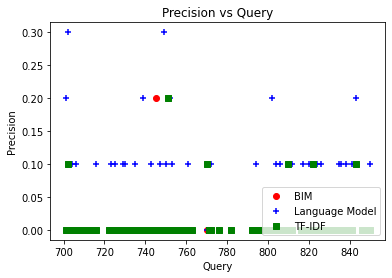

In [46]:
plt.scatter(df_bim['Query_id'], df_bim['Precision'], marker='o', color='red')
plt.scatter(df_bim['Query_id'], df_lm['Precision'], marker='+', color='blue')
plt.scatter(df_bim['Query_id'], df_tf_idf['Precision'], marker='s', color='green')

 
# naming the x axis
plt.xlabel('Query')
# naming the y axis
plt.ylabel('Precision')

plt.legend(['BIM', 'Language Model', 'TF-IDF'], loc='lower right')
 
# giving a title to my graph
plt.title('Precision vs Query')
 
# function to show the plot
plt.show()

#### Recall

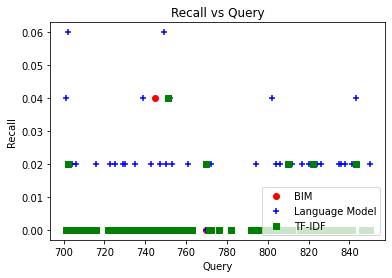

In [47]:
plt.scatter(df_bim['Query_id'], df_bim['Recall'], marker='o', color='red')
plt.scatter(df_bim['Query_id'], df_lm['Recall'], marker='+', color='blue')
plt.scatter(df_bim['Query_id'], df_tf_idf['Recall'], marker='s', color='green')

 
# naming the x axis
plt.xlabel('Query')
# naming the y axis
plt.ylabel('Recall')

plt.legend(['BIM', 'Language Model', 'TF-IDF'], loc='lower right')
 
# giving a title to my graph
plt.title('Recall vs Query')
 
# function to show the plot
plt.show()

#### Average precision

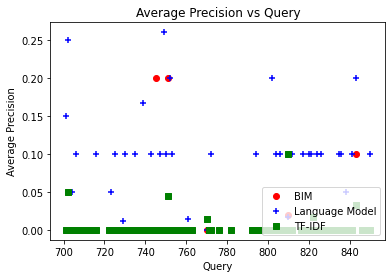

In [48]:
plt.scatter(df_bim['Query_id'], df_bim['Avg_Precision'], marker='o', color='red')
plt.scatter(df_bim['Query_id'], df_lm['Avg_Precision'], marker='+', color='blue')
plt.scatter(df_bim['Query_id'], df_tf_idf['Avg_Precision'], marker='s', color='green')

 
# naming the x axis
plt.xlabel('Query')
# naming the y axis
plt.ylabel('Average Precision')

plt.legend(['BIM', 'Language Model', 'TF-IDF'], loc='lower right')
 
# giving a title to my graph
plt.title('Average Precision vs Query')
 
# function to show the plot
plt.show()